# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  70.25 sec.


In [4]:
out_dir = out_dir = '../data/out_dev/'

In [5]:
nx0 = imgs0.shape[1]
nx_crop = 128
N = 80000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
Shuffle = False
N = 80000
Taking FFT of the images:
Batch 1/10  22.03 sec.
Batch 2/10  22.14 sec.
Batch 3/10  21.96 sec.
Batch 4/10  21.95 sec.
Batch 5/10  24.19 sec.
Batch 6/10  24.21 sec.
Batch 7/10  23.33 sec.
Batch 8/10  24.24 sec.
Batch 9/10  23.53 sec.
Batch 10/10  24.23 sec.
FFT done. Time:  283.65 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.28000000e+02]
Vectorised imgs_f.shape = (80000, 16384)
Mask radius = 0.1502862595419847
Estimating the noise using the 48 x 48 corners of the first 1000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time:  20.92 sec.


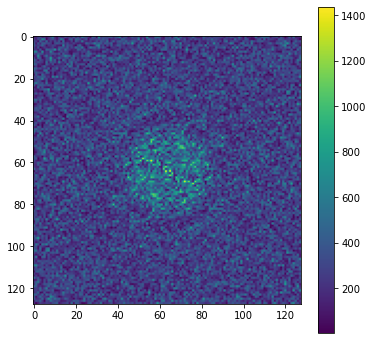

In [6]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[2135].reshape([128,128]))));plt.colorbar()

In [7]:
del(imgs0)

### Only volume reconstruction for now - SGD

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different

In [8]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [9]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [10]:
alpha = 1e-9

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

In [11]:
N_epochs = 20
batch_size = 32
step_size = 1000000 # 1e-3

idxrand = np.random.permutation(N)
idx1 = idxrand[:int(N/2)]
idx2 = idxrand[int(N/2):]
             
grad_func1, loss_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [12]:
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


Epoch 1/20 

100%|██████████| 1250/1250 [00:55<00:00, 22.62it/s, grad=3.037e-04, loss=5820.65]


  |Grad| = 2.872e-04
  |Loss| = 5735.878
Epoch 2/20 

100%|██████████| 1250/1250 [00:46<00:00, 27.10it/s, grad=2.583e-04, loss=5724.84]


  |Grad| = 2.879e-04
  |Loss| = 5736.818
Epoch 3/20 

100%|██████████| 1250/1250 [00:46<00:00, 27.11it/s, grad=2.856e-04, loss=5781.53]


  |Grad| = 2.867e-04
  |Loss| = 5736.797
Epoch 4/20 

100%|██████████| 1250/1250 [00:45<00:00, 27.71it/s, grad=2.423e-04, loss=5689.86]


  |Grad| = 2.879e-04
  |Loss| = 5736.917
Epoch 5/20 

100%|██████████| 1250/1250 [00:45<00:00, 27.63it/s, grad=2.767e-04, loss=5747.26]


  |Grad| = 2.874e-04
  |Loss| = 5736.858
Epoch 6/20 

100%|██████████| 1250/1250 [00:44<00:00, 27.85it/s, grad=2.855e-04, loss=5727.92]


  |Grad| = 2.861e-04
  |Loss| = 5736.759
Epoch 7/20 

100%|██████████| 1250/1250 [00:45<00:00, 27.67it/s, grad=2.772e-04, loss=5720.17]


  |Grad| = 2.872e-04
  |Loss| = 5736.934
Epoch 8/20 

100%|██████████| 1250/1250 [00:45<00:00, 27.35it/s, grad=2.730e-04, loss=5737.90]


  |Grad| = 2.863e-04
  |Loss| = 5736.837
Epoch 9/20 

100%|██████████| 1250/1250 [00:45<00:00, 27.76it/s, grad=2.677e-04, loss=5707.33]


  |Grad| = 2.875e-04
  |Loss| = 5736.895
Epoch 10/20 

100%|██████████| 1250/1250 [00:44<00:00, 27.82it/s, grad=3.158e-04, loss=5773.87]


  |Grad| = 2.879e-04
  |Loss| = 5736.861
Epoch 11/20 

100%|██████████| 1250/1250 [00:45<00:00, 27.73it/s, grad=3.234e-04, loss=5750.18]


  |Grad| = 2.883e-04
  |Loss| = 5736.933
Epoch 12/20 

100%|██████████| 1250/1250 [00:44<00:00, 27.93it/s, grad=3.327e-04, loss=5758.02]


  |Grad| = 2.865e-04
  |Loss| = 5736.922
Epoch 13/20 

100%|██████████| 1250/1250 [00:46<00:00, 27.00it/s, grad=2.786e-04, loss=5676.58]


  |Grad| = 2.880e-04
  |Loss| = 5736.861
Epoch 14/20 

100%|██████████| 1250/1250 [00:46<00:00, 26.61it/s, grad=2.883e-04, loss=5781.91]


  |Grad| = 2.876e-04
  |Loss| = 5736.844
Epoch 15/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.19it/s, grad=2.882e-04, loss=5789.51]


  |Grad| = 2.874e-04
  |Loss| = 5736.900
Epoch 16/20 

100%|██████████| 1250/1250 [00:48<00:00, 25.94it/s, grad=3.104e-04, loss=5765.08]


  |Grad| = 2.876e-04
  |Loss| = 5736.892
Epoch 17/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.28it/s, grad=2.918e-04, loss=5680.72]


  |Grad| = 2.868e-04
  |Loss| = 5736.760
Epoch 18/20 

100%|██████████| 1250/1250 [00:48<00:00, 25.93it/s, grad=2.746e-04, loss=5709.75]


  |Grad| = 2.879e-04
  |Loss| = 5736.942
Epoch 19/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.21it/s, grad=2.860e-04, loss=5792.17]


  |Grad| = 2.868e-04
  |Loss| = 5736.893
Epoch 20/20 

100%|██████████| 1250/1250 [00:48<00:00, 26.00it/s, grad=3.095e-04, loss=5724.00]


  |Grad| = 2.884e-04
  |Loss| = 5736.810


In [13]:
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


Epoch 1/20 

100%|██████████| 1250/1250 [00:48<00:00, 26.01it/s, grad=3.910e-04, loss=5712.68]


  |Grad| = 2.880e-04
  |Loss| = 5734.515
Epoch 2/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.10it/s, grad=3.290e-04, loss=5687.15]


  |Grad| = 2.880e-04
  |Loss| = 5735.463
Epoch 3/20 

100%|██████████| 1250/1250 [00:48<00:00, 26.01it/s, grad=2.724e-04, loss=5666.11]


  |Grad| = 2.893e-04
  |Loss| = 5735.374
Epoch 4/20 

100%|██████████| 1250/1250 [00:48<00:00, 25.85it/s, grad=2.891e-04, loss=5756.64]


  |Grad| = 2.874e-04
  |Loss| = 5735.313
Epoch 5/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.11it/s, grad=2.623e-04, loss=5762.03]


  |Grad| = 2.872e-04
  |Loss| = 5735.381
Epoch 6/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.08it/s, grad=2.755e-04, loss=5781.14]


  |Grad| = 2.876e-04
  |Loss| = 5735.429
Epoch 7/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.07it/s, grad=2.968e-04, loss=5799.38]


  |Grad| = 2.889e-04
  |Loss| = 5735.397
Epoch 8/20 

100%|██████████| 1250/1250 [00:48<00:00, 25.94it/s, grad=2.743e-04, loss=5717.94]


  |Grad| = 2.867e-04
  |Loss| = 5735.281
Epoch 9/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.11it/s, grad=2.778e-04, loss=5759.95]


  |Grad| = 2.887e-04
  |Loss| = 5735.376
Epoch 10/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.13it/s, grad=3.216e-04, loss=5735.15]


  |Grad| = 2.874e-04
  |Loss| = 5735.360
Epoch 11/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.07it/s, grad=2.930e-04, loss=5775.79]


  |Grad| = 2.875e-04
  |Loss| = 5735.406
Epoch 12/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.18it/s, grad=2.438e-04, loss=5676.74]


  |Grad| = 2.886e-04
  |Loss| = 5735.420
Epoch 13/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.37it/s, grad=3.199e-04, loss=5782.01]


  |Grad| = 2.878e-04
  |Loss| = 5735.343
Epoch 14/20 

100%|██████████| 1250/1250 [00:48<00:00, 26.02it/s, grad=3.391e-04, loss=5751.15]


  |Grad| = 2.873e-04
  |Loss| = 5735.389
Epoch 15/20 

100%|██████████| 1250/1250 [00:48<00:00, 25.96it/s, grad=2.526e-04, loss=5703.40]


  |Grad| = 2.870e-04
  |Loss| = 5735.372
Epoch 16/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.29it/s, grad=2.791e-04, loss=5786.69]


  |Grad| = 2.883e-04
  |Loss| = 5735.403
Epoch 17/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.19it/s, grad=2.778e-04, loss=5755.50]


  |Grad| = 2.886e-04
  |Loss| = 5735.384
Epoch 18/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.28it/s, grad=2.474e-04, loss=5712.11]


  |Grad| = 2.871e-04
  |Loss| = 5735.368
Epoch 19/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.11it/s, grad=2.407e-04, loss=5702.15]


  |Grad| = 2.880e-04
  |Loss| = 5735.433
Epoch 20/20 

100%|██████████| 1250/1250 [00:47<00:00, 26.05it/s, grad=3.254e-04, loss=5698.74]


  |Grad| = 2.879e-04
  |Loss| = 5735.374


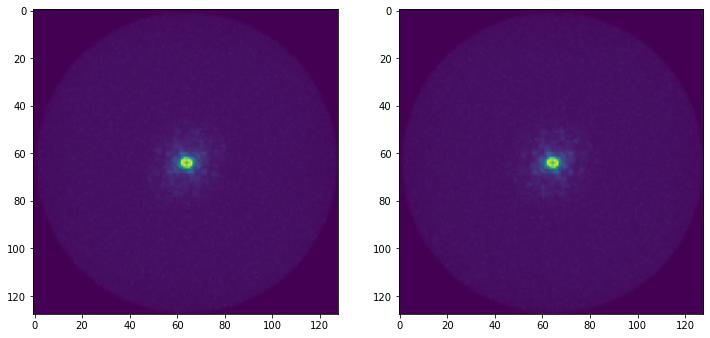

In [14]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); #plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); #plt.colorbar()

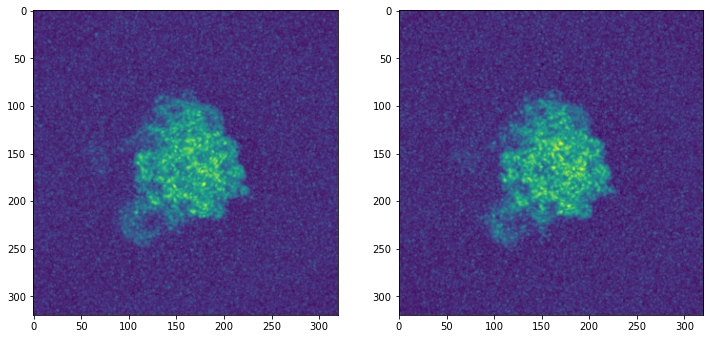

In [15]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [16]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

#### FSC

In [17]:
print(v_rec1.shape)
print(v_rec2.shape)
print(x_grid)

(128, 128, 128)
(128, 128, 128)
[2.38549618e-03 1.28000000e+02]


In [18]:
res, fsc, shell_points = calc_fsc(v_rec1, v_rec2, [1, 128])

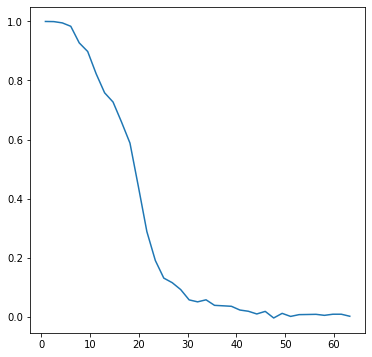

In [19]:
plt.plot(res, fsc)

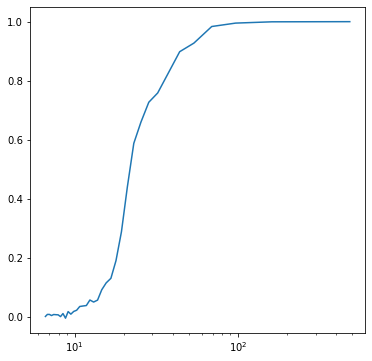

In [20]:
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc)

In [21]:
fsc

DeviceArray([ 1.00000000e+00,  9.99494163e-01,  9.95137682e-01,
              9.83599241e-01,  9.27383737e-01,  8.98213036e-01,
              8.22776270e-01,  7.58305584e-01,  7.26946149e-01,
              6.59310060e-01,  5.87828779e-01,  4.39833499e-01,
              2.87831677e-01,  1.90053962e-01,  1.30345724e-01,
              1.14786971e-01,  9.14352845e-02,  5.64986322e-02,
              4.98710087e-02,  5.67555784e-02,  3.80238157e-02,
              3.64662076e-02,  3.47934296e-02,  2.21241232e-02,
              1.80042393e-02,  8.83185179e-03,  1.75356642e-02,
             -4.78319189e-03,  1.08463424e-02,  5.03600990e-04,
              6.52292850e-03,  7.00082983e-03,  7.58051112e-03,
              4.14123215e-03,  7.90908912e-03,  7.92359039e-03,
              1.05838581e-03], dtype=float64)

In [26]:
fsc[10]

DeviceArray(0.58782878, dtype=float64)

In [27]:
fsc[11]

DeviceArray(0.4398335, dtype=float64)

In [28]:
res_angs[10]

DeviceArray(23.05002218, dtype=float64)

In [29]:
res_angs[11]

DeviceArray(21.04567242, dtype=float64)